In [21]:
#Imports 
import torch
import copy
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

#Checking Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
#Dataset Class Definition
class FinSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [23]:
#Loading Tokeniser
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [24]:
#Loading Validation Splits
X_tw_val = pd.read_csv("data/splits/twitter_val_text.csv").squeeze()
y_tw_val = pd.read_csv("data/splits/twitter_val_labels.csv").squeeze()

X_news_val = pd.read_csv("data/splits/news_val_text.csv").squeeze()
y_news_val = pd.read_csv("data/splits/news_val_labels.csv").squeeze()

X_reports_val = pd.read_csv("data/splits/reports_val_text.csv").squeeze()
y_reports_val = pd.read_csv("data/splits/reports_val_labels.csv").squeeze()

print("Validation splits loaded")

Validation splits loaded


In [25]:
#DataLoaders
tw_val_loader = DataLoader(
    FinSentimentDataset(X_tw_val, y_tw_val, tokenizer),
    batch_size=16,
    shuffle=False
)

news_val_loader = DataLoader(
    FinSentimentDataset(X_news_val, y_news_val, tokenizer),
    batch_size=16,
    shuffle=False
)

reports_val_loader = DataLoader(
    FinSentimentDataset(X_reports_val, y_reports_val, tokenizer),
    batch_size=16,
    shuffle=False
)

print("Validation DataLoaders ready")

Validation DataLoaders ready


In [26]:
#Loading Full Processed Dataset
twitter = pd.read_csv("data/processed/twitter.csv")
news = pd.read_csv("data/processed/news.csv")
reports = pd.read_csv("data/processed/reports.csv")

print("Training data loaded")

Training data loaded


In [27]:
#Recreating Train Loaders
from sklearn.model_selection import train_test_split

#Function
def create_train_loader(df):
    X = df["text"]
    y = df["label"]

    X_train, _, y_train, _ = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    dataset = FinSentimentDataset(X_train, y_train, tokenizer)
    return DataLoader(dataset, batch_size=16, shuffle=True), len(dataset)

#For each Client
tw_train_loader, tw_size = create_train_loader(twitter)
news_train_loader, news_size = create_train_loader(news)
reports_train_loader, reports_size = create_train_loader(reports)

print("Train loaders created")

Train loaders created


In [28]:
#Defining Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].numpy())

    acc = accuracy_score(all_labels, all_preds)
    _, _, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    return acc, f1

In [29]:
#Initialising a Global Model
global_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3
).to(device)

print("Global model initialized (FedProx)")

Global model initialized (FedProx)


In [30]:
from transformers import AutoModelForSequenceClassification

def init_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert",
        num_labels=3
    )
    model.to(device)
    return model

In [31]:
#Local Train Function Different from FedAvg as in FedProx, Loss = Task Loss + Mew
def local_train_fedprox(model, global_model, train_loader, mu, epochs=3):
    model.train()
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Store global parameters
    global_params = {
        name: param.detach().clone()
        for name, param in global_model.named_parameters()
    }

    for _ in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )

            loss = outputs.loss

            # FedProx proximal term
            prox_term = 0.0
            for name, param in model.named_parameters():
                prox_term += torch.norm(param - global_params[name]) ** 2

            loss = loss + (mu / 2) * prox_term

            loss.backward()
            optimizer.step()

    return model

In [32]:
#FedAvg Unchanged
def fedavg(global_model, client_models, client_sizes):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = sum(
            client_sizes[i] * client_models[i].state_dict()[key]
            for i in range(len(client_models))
        ) / sum(client_sizes)

    global_model.load_state_dict(global_dict)
    return global_model

In [13]:
#FedProx Training for Each Mew
MU_VALUES = [0.01, 0.05, 0.1]

ROUNDS = 10
LOCAL_EPOCHS = 3

fedprox_results = {}

for mu in MU_VALUES:
    print(f"\n===== FedProx Training (mu = {mu}) =====")

    global_model = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert",
        num_labels=3
    ).to(device)

    results = []

    for r in range(ROUNDS):
        print(f"--- Round {r+1}/{ROUNDS} ---")

        tw_model = copy.deepcopy(global_model)
        news_model = copy.deepcopy(global_model)
        reports_model = copy.deepcopy(global_model)

        tw_model = local_train_fedprox(
            tw_model, global_model, tw_train_loader, mu, LOCAL_EPOCHS
        )
        news_model = local_train_fedprox(
            news_model, global_model, news_train_loader, mu, LOCAL_EPOCHS
        )
        reports_model = local_train_fedprox(
            reports_model, global_model, reports_train_loader, mu, LOCAL_EPOCHS
        )

        global_model = fedavg(
            global_model,
            [tw_model, news_model, reports_model],
            [tw_size, news_size, reports_size]
        )

        acc_t, f1_t = evaluate_model(global_model, tw_val_loader)
        acc_n, f1_n = evaluate_model(global_model, news_val_loader)
        acc_r, f1_r = evaluate_model(global_model, reports_val_loader)

        avg_f1 = (f1_t + f1_n + f1_r) / 3

        results.append([r+1, f1_t, f1_n, f1_r, avg_f1])

        print(f"Avg F1: {avg_f1:.4f}")

    fedprox_results[mu] = results


===== FedProx Training (mu = 0.01) =====
--- Round 1/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.5789
--- Round 2/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.7609
--- Round 3/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8306
--- Round 4/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8337
--- Round 5/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8328
--- Round 6/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8421
--- Round 7/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8447
--- Round 8/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8414
--- Round 9/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8415
--- Round 10/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8474

===== FedProx Training (mu = 0.05) =====
--- Round 1/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.4891
--- Round 2/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.7656
--- Round 3/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8219
--- Round 4/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8148
--- Round 5/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8244
--- Round 6/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8288
--- Round 7/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8349
--- Round 8/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8427
--- Round 9/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8414
--- Round 10/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8551

===== FedProx Training (mu = 0.1) =====
--- Round 1/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.4929
--- Round 2/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.7226
--- Round 3/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.7897
--- Round 4/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8141
--- Round 5/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8268
--- Round 6/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8351
--- Round 7/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8403
--- Round 8/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8422
--- Round 9/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8423
--- Round 10/10 ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avg F1: 0.8421


In [14]:
fedprox_dfs = {}

for mu, data in fedprox_results.items():
    df = pd.DataFrame(
        data,
        columns=["Round", "Twitter_F1", "News_F1", "Reports_F1", "Avg_F1"]
    )
    fedprox_dfs[mu] = df
    print(f"\nFedProx results (mu={mu})")
    display(df.tail(1))


FedProx results (mu=0.01)


,Round,Twitter_F1,News_F1,Reports_F1,Avg_F1
9,10,0.802459,0.910084,0.829638,0.847394



FedProx results (mu=0.05)


,Round,Twitter_F1,News_F1,Reports_F1,Avg_F1
9,10,0.801269,0.927638,0.83631,0.855072



FedProx results (mu=0.1)


,Round,Twitter_F1,News_F1,Reports_F1,Avg_F1
9,10,0.806008,0.896737,0.82346,0.842068


In [15]:
import os

os.makedirs("results/fedprox", exist_ok=True)

for mu, df in fedprox_dfs.items():
    df.to_csv(f"results/fedprox/fedprox_mu_{mu}.csv", index=False)

print("All FedProx result tables saved")

All FedProx result tables saved


In [34]:
#Retraining FedPRox with best Mew
BEST_MU = 0.05
ROUNDS = 10
LOCAL_EPOCHS = 3

global_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3
).to(device)

for r in range(ROUNDS):
    print(f"\n===== FedProx Round {r+1}/{ROUNDS} (μ={BEST_MU}) =====")

    tw_model = copy.deepcopy(global_model)
    news_model = copy.deepcopy(global_model)
    reports_model = copy.deepcopy(global_model)

    tw_model = local_train_fedprox(
        tw_model, global_model, tw_train_loader, BEST_MU, LOCAL_EPOCHS
    )
    news_model = local_train_fedprox(
        news_model, global_model, news_train_loader, BEST_MU, LOCAL_EPOCHS
    )
    reports_model = local_train_fedprox(
        reports_model, global_model, reports_train_loader, BEST_MU, LOCAL_EPOCHS
    )

    global_model = fedavg(
        global_model,
        [tw_model, news_model, reports_model],
        [tw_size, news_size, reports_size]
    )

print("FedProx retraining with best μ completed")


===== FedProx Round 1/10 (μ=0.05) =====

===== FedProx Round 2/10 (μ=0.05) =====

===== FedProx Round 3/10 (μ=0.05) =====

===== FedProx Round 4/10 (μ=0.05) =====

===== FedProx Round 5/10 (μ=0.05) =====

===== FedProx Round 6/10 (μ=0.05) =====

===== FedProx Round 7/10 (μ=0.05) =====

===== FedProx Round 8/10 (μ=0.05) =====

===== FedProx Round 9/10 (μ=0.05) =====

===== FedProx Round 10/10 (μ=0.05) =====
FedProx retraining with best μ completed


In [36]:
#Saving Model
import os

os.makedirs("models/global_fedprox_mu_0.05", exist_ok=True)

global_model.save_pretrained("models/global_fedprox_mu_0.05")
tokenizer.save_pretrained("models/global_fedprox_mu_0.05")

print("Best FedProx model (μ=0.05) saved successfully")

Best FedProx model (μ=0.05) saved successfully


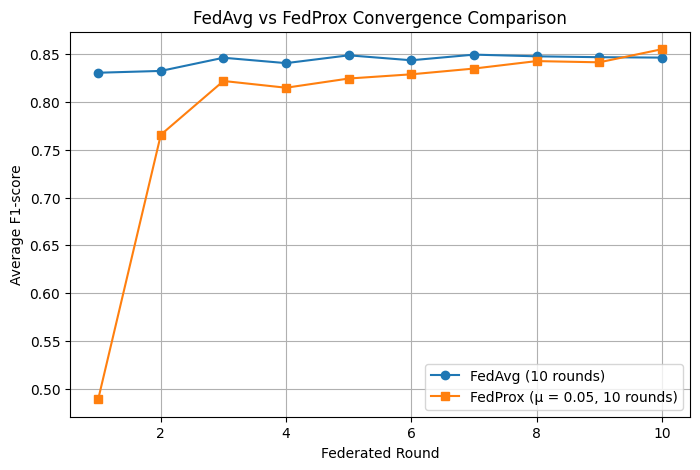

In [3]:
#FedAvg vs FedProx Plot
import pandas as pd
import matplotlib.pyplot as plt

#Loading FedAvg (10 rounds)
fedavg_df = pd.read_csv("results/fedavg/fedavg_10_rounds.csv")

#Loading Best FedProx (mu = 0.05)
fedprox_df = pd.read_csv("results/fedprox/fedprox_mu_0.05.csv")

plt.figure(figsize=(8,5))

plt.plot(fedavg_df["Round"], fedavg_df["Avg_F1"],
         marker="o", label="FedAvg (10 rounds)")

plt.plot(fedprox_df["Round"], fedprox_df["Avg_F1"],
         marker="s", label="FedProx (μ = 0.05, 10 rounds)")

plt.xlabel("Federated Round")
plt.ylabel("Average F1-score")
plt.title("FedAvg vs FedProx Convergence Comparison")
plt.grid(True)
plt.legend()
plt.savefig("results/fedavg_vs_fedprox.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
summary = pd.DataFrame({
    "Method" : ["FedAvg (10)", "FedProx μ=0.05 (10)"],
    "Final Avg F1" : [
        fedavg_df["Avg_F1"].iloc[-1],
        fedprox_df["Avg_F1"].iloc[-1]
    ]
})

print(summary)

                Method  Final Avg F1
0          FedAvg (10)      0.846312
1  FedProx μ=0.05 (10)      0.855072
